<a href="https://colab.research.google.com/github/dkaratzas/DL2024-25/blob/main/Problems%201%20-%20Autograd/P1_AutoGrad_onScalars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2024-25/blob/main/Problems%201%20-%20Autograd/P1_AutoGrad_onScalars.ipynb)


# Creating our own Auto Differentiation (AutoGrad) framework

In this practical exercise we will build our own, very simple, Auto-differentiation (or AutoGrad) framework.


## Coding the framework

### Step 1: Define a class for our variables


The key idea is that we will define our own class of `Variable` which is basically the same as a scalar (a number). So our class is created by passing it a `value`, and it stores this value internally.

But apart from being a placeholder for a number, we also want to keep track of the operation that created every `Variable`.

For example, if a variable $c$ is the result of the addition of two variables $a$ and $b$: $c = a + b$, then we would say that $a$ and $b$ are "parent" variables of $c$, and $c$ is their "child". The way $c$ was created was by adding these two parent variables together. A variable created directly (defined by the user, not resulting by any operation over existing variables) would have no parents.

So apart from the value of the `Variable`, we will also have to keep track of its parents, and on how each of them "contributes" to the value of the `Variable` - this is described by the local derivative associated with each of the parents, that tells us how a change in the value of each of the parent variables translates into a change in the value of the child variable.

This is important in order to implement our backwards pass. During the backwards pass each parent defines a "route" through which the gradients coming into our variable will have to flow through.

So we will define a list of `gradRoutes` that will contain the list of parent variables and their corresponding local derivatives. A `Variable` created directly (not resulting by any operation over existing variables) will have an empty `gradRoutes`.

Finally, we want each `Variable` of ours to keep track of the value of gradient of the quantity we are interested in (usually the loss) with respect to the `Variable` itself. We will create a placeholder for that as well, called `grad`. As seen in theory, this placeholder will accummulate the gradients that are backpropagated from the children of this variable when we implement the backpropagation algorithm. So we will initialise it to zero.


In [21]:
import numpy as np

In [22]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes: list[tuple] = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0        
        
    def __str__(self):
        return 'Value: {self.value}'.format(self=self)        

Apart from the `__init__()` function which stores the value passed to our class and initialises the `gradRoutes` and `grad` member variables, we have also overloaded the function that python uses to convert a class into a string representation: `__str__()`. This will allow us to print our class.

We cannot do much yet with this class, apart from storing values into our variables and printing them out. Let's try this out. 


In [23]:
a = Variable(4.3)
b = Variable(5.2)
c = Variable(1)
print(a)
print(b)
print(c)

Value: 4.3
Value: 5.2
Value: 1


### Step 2: Define operations over our variables


The next step would be to implement operations on our variables. Let's first define the operations for addition and multiplication.

These will be functions that take two `variables` as input and produce a new (child) `variable` with a value equal to the sum or the product of the two inputs. Apart from the forward pass though, we should keep track of how this new `variable` was created: the two parent `variables`, and their corresponding local derivatives. In our code we put these two things in a tuple and save them in the list of `gradRoutes`.


In [24]:
def vAdd(A, B): # Addition
    result = Variable(A.value + B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1)) # dresult / dA = 1
    result.gradRoutes.append((B, 1)) # dresult / dB = 1
    
    return result
    
def vMul(A, B): # Addition
    result = Variable(A.value * B.value) # Create a new Variable to store the result, and pass it the value = a * b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, B.value)) # dresult / dA = B
    result.gradRoutes.append((B, A.value)) # dresult / dB = A
    
    return result

So for example to calculate $d = (a + b) * c$ we first need to calculate $(a + b)$ and then mutiply the result with $c$


In [25]:
a = Variable(2) # a = 2
b = Variable(3) # b = 3
c = Variable(4) # c = 4

#d = (a + b) * c = 20
d = vMul(vAdd(a, b), c)

print(d)

Value: 20


### Step 3: Implement the backpropagation function


The final step is to implement the backpropagation function. This starts with a child `variable`, and backpropagates gradients through the routes recursively. It uses the two rules that we saw in theory:

- Accumulate the incoming gradients that arrive to a `variable`. Each of the incoming gradients describe a different way in which the `variable` affects the quantity of interest, so this sum will be the final gradient for the `variable`
- Multiply every incoming gradient with each of the local derivatives corresponding to parent `variables` (this would be the application of the chain rule), and continue the backpropagation through the corresponding route (for each of the parent `variables`)

We update the `Variable` class accordingly. We also update the `__str___()` function to include also gradient information.


In [26]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)

    def zero_grad(self):
        self.grad = 0

        for variable, _ in self.gradRoutes:
            variable.zero_grad()
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

<font color=blue>**Question:** Why did we set the default value of route_val equal to 1.0?</font>


---

Because in case that we do not provide a gradient value we assume the operation has not changed the variable, therefore its derivative should be one.


---


This should be all. If we want to calculate the derivative of the result with respect to any of the variables that participated in the calculation, we just need to call backprop on the result, and then read the derivatives out.


In [27]:
a = Variable(2)           # a = 2
b = Variable(3)           # b = 3
c = Variable(4)           # c = 4
res = vMul(vAdd(a, b), c) # res = (a + b) * c = 20

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
print("The derivative of the result with respect to c is:", c.grad)

Result = 20
The derivative of the result with respect to a is: 4.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 5.0


In the following example, variable $a$ affects the result through two different routes


In [28]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = vAdd(a, b)   # c = 4 + 3
res = vMul(a, c) # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", c.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


<font color=blue>**Question:** Can you now use this setup to calculate the derivative of $c$ with respect to $a$ and $b$?</font>


In [29]:
# Your Code Here
res.zero_grad()

c.backProp()

print(b.grad)
print(a.grad)

1.0
1.0


## Final touches

If you understood how this works up to here, then you should be already good to go. But since we want to use our auto grad to do some practical work, we will continue working on it a bit, to make it a bit more usable and complete it with more operations. Many of the subsequent steps are quite "engineering" in nature.


### Improving usability: overloading operators


Of course this is still highly incomplete, very inefficient and not very usable. Lets first improve a usability issue. Instead of having to call different functions for the operations like `res = vMul(a, c)`, we would like to be able to directly write them down like `res = a * b`. To achieve this, we should overload [Python's special functions for operator overloading](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types).

Here's how to do this for the addition and multiplication.


In [30]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)            
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

    def zero_grad(self):
        self.grad = 0

        for variable, _ in self.gradRoutes:
            variable.zero_grad()

In [31]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = a + b        # c = 4 + 3
res = a * c      # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", b.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


### Zeroing gradients


A last thing to note is that once we call `backProp`, our gradients are calculated and our variables are now "dirty" in the sense that if we call backprop again, the new result will be added to the previous one:


In [32]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
The derivative of the result with respect to a is: 22.0
The derivative of the result with respect to b is: 8.0


This will actually turn out to be quite useful, e.g. when we want to accumulate weight gradients over different samples in our learning loops (see next week's notebook), but we need a way to control it.

To avoid this, we should reset the gradients to zero before we call `backProp` again. We can do it one by one for every variable, but we will also implement a function that does this recursively from the child node we backProped, all the way to the parents.


In [33]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)           
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [34]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Zero gradients
res.zeroGrad()

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
The derivative of the result with respect to a is: 22.0
The derivative of the result with respect to b is: 8.0


## More Improvements - Homework


There are number of ways we can improve our simple network. The most important is probably being able to work with vectors and matrices - we will not implement this ourselves though, next week we will see a framework that does this. For the time being, we will focus on other, simpler improvements.


---
### <font color=blue>Exercise 1 (Easy):</font>
    
<font color=blue>We usually do not require gradients for all our variables. If we could indicate which variables require gradients, then we could keep track of the routes that lead to these variables only and drop all the rest. This would be a huge improvement in resources and speed (number of calculations). Add a boolean parameter in the Variable class initialization called `requiresGrad`, and use it to add this functionality.</font>


In [35]:
# Your Code Here
class Variable: #Simple variable. These are the leafs of our tree, they can r
    def __init__(self, value, requiresGrad=False):
        self.value = value
        self.requiresGrad = requiresGrad
        self.gradRoutes = [] # A variable by default has no grad Routes (was 
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        if not self.requiresGrad:
            return

        # Add together the incoming gradients from the different routes that 
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value 
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corre
            variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            if not variable.requiresGrad:
                variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)           
    
    def __str__(self):
        if self.requiresGrad:
            return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)
        else:
            return 'Value: {self.value}, Gradient: Not Required'.format(self=self)

    # easy printing on terminal ;)
    def __repr__(self) -> str:
        return str(self)

Since the default is set to False, we need to also call `res.requiresGrad = True` to be able to calculate its gradient, otherwise the default on the init method is used. Remember that the init function is called when returning from the operations like `vAdd` and `vMul`.


In [36]:
a = Variable(1, requiresGrad=True)
b = Variable(2, requiresGrad=True)
res = a * b
res.requiresGrad = True

res.backProp()
print(res)
print(a)
print(b)

Value: 2, Gradient: 1.0
Value: 1, Gradient: 2.0
Value: 2, Gradient: 1.0


In [37]:
# Now we try to NOT calculate the gradient.

a = Variable(1, requiresGrad=True)
b = Variable(2, requiresGrad=True)
res = a * b
# we do not calculate the gradient
#res.requiresGrad = True

res.backProp()
print(res)
print(a)
print(b)

Value: 2, Gradient: Not Required
Value: 1, Gradient: 0.0
Value: 2, Gradient: 0.0


---
### <font color=blue>Exercise 2 (Normal):</font>
    
<font color=blue>We obviously need to implement more functions - implement the following functions:
- Subtraction
- Raising to a power
- Division
- Unary negation
- The (natural) exponential function exp(x)
- ... any other function you might want</font>


In [38]:
# Your Code Here

# IMPORTANT: SOLVED AT THE END OF THE FILE

---
### <font color=blue>Exercise 3 (Difficult):</font>
    
<font color=blue>Our operations currently accept only instances of our Variable class as inputs. So, if you wanted to calculate `a = b * 2` where `b` is an instance of our variable class and `2` is just a numerical constant you would get an error as our framework does not know how to multiply a `Variable` with a number. You should instead write `a = b * Variable(2)` to achieve this.</font>

<font color=blue>Improve further the usability of our framework by allowing our functions to mix numbers and Variables in the same operation. To do this, you should check the type of each operand, and if it is not a `Variable`, convert it to a `Variable` before you continue.</font>

*Hint: look at the `isinstance()` function*

*Hint: look also into the overloads of the [reflected operands in python](https://docs.python.org/3/reference/datamodel.html#object.__radd__)*


In [39]:
# Your Code Here

# IMPORTANT: SOLVED AT THE END OF THE FILE

---
### <font color=blue>Exercise 4 (Very Difficult):</font>

When we create a new variable through an operation, we create gradRoutes to all the parent variables and calculate the value of the local derivative. The sole purpose of calculating this value is to use it as a multiplier during backProp.

During the backprop operation, everytime our Variable receives a gradient it multiplies it with the local derivative value of each gradRoute (that was calcualted during the forward pass), and passes it back to the corresponding parent Variable. 

It seems a bit strange that it is our Variable that has to keep track of these local derivative values and do this multiplication... In addition, this is a multiplication only because we deal with scalars, if we were implementing tensor (vector, matrix, tensor) operations we would have to substitute this scalar multiplication with a tensor operation...

It is better if our Variable does not have to bother about all these. What exactly we should do when we push the gradient back depends on the operation. It would be better, if each operation gave us the recipe of what to do during backprop. This would mean that every time we perform an operation, the operation defines and gives us a small function that is what we should call during backProp. This way, each operation keeps responsibility about how backprop should be implemented through it, and our Variable just needs to call this small function.

Keeping track of this function instead of the local derivative value will allow us to easily extend this framework to tensor operations. In addition, keeping a note of the function instead of the value, allows us to abstract away stuff. This basically means that we can build the computation graph first, with placeholder variables independently of specific input values, and then reuse it for different inputs. This is how many deep learning frameworks work.

<font color=blue>How to implement this? Every time you do an operation and create a new gradRoute, instead of calculating and storing a value for the local derivative, define a small function that calculates this local derivative value, takes the gradient that is being backpropagated and multiplies (or otherwise, depending on the operation) the two things.</font>


In [40]:
# Your Code Here

# IMPORTANT: SOLVED AT THE END OF THE FILE

---
### <font color=blue>Exercise 5 (Easy):</font>
    
<font color=blue>Write some code to manually check that your gradient calculation is correct, using the property of:</font>

<font color=blue>$$f'(x) = \frac {f(x+\epsilon) - f(x-\epsilon)}{2 \epsilon}$$ where $\epsilon$ is a very small number to approximately calculate the gradient.</font>

<font color=blue>Then use it to calculate the derivative of the function $f(x) = 21 * x^3$ at $x=3.2$. Double check that our framework gives you the same result.</font>


In [69]:
# Your Code Here

def function(x):
    return 21*x**3

x_tensor = Tensor(3.2, requires_grad=True)
f_tensor = 21*x_tensor**3
f_tensor.backprop()

def numerical_gradient(f, x_var: float):
    epsilon = 10**(-4)
    pos = f(x_var + epsilon)
    neg = f(x_var - epsilon)

    return (pos - neg)/(2*epsilon)

num_grad = numerical_gradient(function, 3.2)


print(f'Numerical Result: {num_grad}')
print(f'Using tensor: {x_tensor.grad = }')

Numerical Result: 645.1200002118185
Using tensor: x_tensor.grad = array(645.12)


#### Warning!!!!! Execute the `Tensor` class defined below

# ALL SOLUTIONS HERE

I started doing the homework on a separate file and it got out of hand. The framework is implemented of top of `numpy`.

All the requirements of the exercises have been achieved:
- The gradient are calculated using a function call everytime.
- Implementation of a stack to perform the backpropagation, only the variables that require a gradient are included.
- `matmul` (using `numpy.dot`) is implemented.
- All operations vectorized using `numpy`
- Constant included, by default the gradient ares not required. The idea is to automatically enable them when creating the model.
- Testing implemented on this [GitHub repo I created](https://github.com/tomiock/tomi_grad). It matched the gradients calculated using the `autograd` package.
- Nearly seamless user experience when creating a model :D

Note: It requires all computations to start with a single scalar. This would usually be achieved using the `.sum()` method implemented on the class. For example you could used to calculate the batch loss when implementing a model.

Sry I didnt separate the exercises, as modifying the code several time was time consuming and I had to send the file.

In [70]:
from collections.abc import Callable
import numpy as np
import numpy.typing as npt


class Tensor:
    def __init__(self, array: npt.ArrayLike, requires_grad=False, precision=np.float64):
        self.requires_grad = requires_grad
        self._grad: npt.ArrayLike | None = None
        # the parents in the computation graph
        # note that the graphs END at the loss or another scalar value
        self.parents: list[tuple[Tensor, Callable]] = []

        # TODO: type check this
        self.precision = precision

        self.arr = np.array(array, dtype=precision)

        self.dim = self.arr.ndim
        self.shape = self.arr.shape

    @property
    def grad(self):
        return self._grad

    def zeroGrad(self):
        self._grad = np.zeros_like(self.arr)

    def _backward(self, _value: np.ndarray = np.array(1.0)):
        if not self.requires_grad:
            return

        visited = set()
        stack = []
        visit_stack = [self]

        while visit_stack:
            node = visit_stack[-1]
            all_parents_visited = True
            for p_node, _ in node.parents:
                if p_node not in visited:
                    all_parents_visited = False
                    visit_stack.append(p_node)
                    break

            if all_parents_visited:
                visit_stack.pop()
                if node not in visited:
                    visited.add(node)
                    stack.append(node)

        _value = np.array(_value, dtype=self.precision)
        self._grad = _value

        for node in reversed(stack):
            if node.grad is None:
                continue
            for prev_node, local_grad in node.parents:
                if prev_node.requires_grad:
                    if prev_node._grad is None:
                        prev_node._grad = np.zeros(prev_node.shape)

                    grad_delta = local_grad(node._grad)
                    if grad_delta.shape != prev_node._grad.shape: # Reshape grad_delta if shape mismatch
                        grad_delta = grad_delta.reshape(prev_node._grad.shape)
                    prev_node._grad += grad_delta

    def backprop(self):
        self._backward()

    def sum(self):
        result_value = np.sum(self.arr)
        result = Tensor(result_value, requires_grad=self.requires_grad)

        if self.requires_grad:

            def _grad_sum(_value):
                return _value * np.ones_like(self.arr)

            result.parents.append((self, _grad_sum))

        return result

    def sqrt(self):
        return vSqrt(self)

    @property
    def T(self):
        return vTranspose(self)

    def get_operation(self):
        raise NotImplementedError

    def get_consumers(self):
        raise NotImplementedError

    def get_inputs(self):
        raise NotImplementedError

    def __add__(self, other):
        other = _to_var(other)
        return vAdd(self, other)

    def __radd__(self, other):
        other = _to_var(other)
        return vAdd(other, self)

    def __sub__(self, other):
        other = _to_var(other)
        return vAdd(self, -1.0 * other)

    def __rsub__(self, other):
        other = _to_var(other)
        return vAdd(other, -1.0 * self)

    def __mul__(self, other):
        other = _to_var(other)
        return vMul(self, other)

    def __rmul__(self, other):
        other = _to_var(other)
        return vMul(other, self)

    def __truediv__(self, b):
        return vMul(self, pow(b, -1.0))

    def __rtruediv__(self, b):
        return vMul(b, pow(self, -1))

    def __pow__(self, other):
        other = _to_var(other)
        return vPow(self, other)

    def __matmul__(self, other):
        other = _to_var(other)
        return vMatMul(self, other)

    def __neg__(self):
        return -1 * self

    def __str__(self):
        return str(self.arr)

    def __repr__(self):
        return str(self.arr)


def _to_var(x):
    if isinstance(x, Tensor):
        x.arr = np.array(x.arr)
        return x
    else:
        x_var = Tensor(x)
        x_var.arr = np.array(x_var.arr)
        return x_var


def vSqrt(A: Tensor):
    A = _to_var(A)
    result = Tensor(np.sqrt(A.arr))
    result.requires_grad = A.requires_grad

    if A.requires_grad:

        def _grad_sqrt(_value):
            return _value * (0.5 / np.sqrt(A.arr))

        result.parents.append((A, _grad_sqrt))
    return result


def vTranspose(A: Tensor):
    A = _to_var(A)
    result = Tensor(A.arr.T, requires_grad=A.requires_grad)
    if A.requires_grad:

        def _grad_t(_value):
            return _value.T

        result.parents.append((A, _grad_t))
    return result


def vMatMul(A: Tensor, B: Tensor):
    A = _to_var(A)
    B = _to_var(B)

    result = np.matmul(A.arr, B.arr)
    required_grad = A.requires_grad or B.requires_grad
    result = Tensor(result, requires_grad=required_grad)

    if A.requires_grad:

        def _grad_a(_value):
            return np.matmul(_value, B.arr.T)  # G @ B.T

        result.parents.append((A, _grad_a))

    if B.requires_grad:

        def _grad_b(_value):
            return np.matmul(A.arr.T, _value)  # A.T @ G

        result.parents.append((B, _grad_b))

    return result


def vAdd(A: Tensor | float | int, B: Tensor | float | int):
    A = _to_var(A)
    B = _to_var(B)

    result = Tensor(A.arr + B.arr, requires_grad=(A.requires_grad or B.requires_grad))

    if A.requires_grad:

        def _grad_a(_value):
            sum_axes = []
            for i in range(len(_value.shape)):
                if i < len(A.shape):
                    if A.shape[i] == 1 and _value.shape[i] > 1:
                        sum_axes.append(i)
                elif i >= len(A.shape):
                    sum_axes.append(i)

            return np.sum(_value, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((A, _grad_a))
    if B.requires_grad:

        def _grad_b(_value):
            sum_axes = []
            for i in range(len(_value.shape)):
                if i < len(B.shape):
                    if B.shape[i] == 1 and _value.shape[i] > 1:
                        sum_axes.append(i)
                elif i >= len(B.shape):
                    sum_axes.append(i)
            return np.sum(_value, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((B, _grad_b))

    return result


def vMul(A: Tensor, B: Tensor):
    A = _to_var(A)
    B = _to_var(B)

    result = Tensor(A.arr * B.arr, requires_grad=(A.requires_grad or B.requires_grad))

    if A.requires_grad:

        def _grad_a(incoming_grad):
            sum_axes = []
            for i in range(len(incoming_grad.shape)):
                if i < len(A.shape):
                    if A.shape[i] == 1 and incoming_grad.shape[i] > 1:
                        sum_axes.append(i)
                elif i >= len(A.shape):
                    sum_axes.append(i)
            return np.sum(incoming_grad * B.arr, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((A, _grad_a))

    if B.requires_grad:

        def _grad_b(incoming_grad):
            sum_axes = []
            for i in range(len(incoming_grad.shape)):
                if i < len(B.shape):
                    if B.shape[i] == 1 and incoming_grad.shape[i] > 1:
                        sum_axes.append(i)
                else:
                    sum_axes.append(i)
            return np.sum(incoming_grad * A.arr, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((B, _grad_b))

    return result


def vPow(A: Tensor, exponent: Tensor):
    A = _to_var(A)
    _exponent = _to_var(exponent)

    _array = np.array(A.arr)
    _exponent = np.array(exponent.arr)
    result = Tensor(
        np.power(_array, _exponent),
        requires_grad=(A.requires_grad or exponent.requires_grad),
    )

    if A.requires_grad:

        def _grad_a(_value):
            local_grad = exponent.arr * np.power(A.arr, exponent.arr - 1)

            sum_axes = []
            for i in range(len(_value.shape)):
                if i < len(A.shape):
                    if A.shape[i] == 1 and _value.shape[i] > 1:
                        sum_axes.append(i)
                elif i >= len(A.shape):
                    sum_axes.append(i)
            return np.sum(_value * local_grad, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((A, _grad_a))

    if exponent.requires_grad:

        def _grad_exponent(_value):
            local_grad = np.power(A.arr, _exponent) * np.log(A.arr)

            sum_axes = []
            for i in range(len(_value.shape)):
                if i < len(_exponent.shape):
                    if exponent.shape[i] == 1 and _value.shape[i] > 1:
                        sum_axes.append(i)
                elif i >= len(_exponent.shape):
                    sum_axes.append(i)
            return np.sum(_value * local_grad, axis=tuple(sum_axes), keepdims=True)

        result.parents.append((exponent, _grad_exponent))

    return result

## Extra: Vectorized Polynomial Regression implemented

The experience is nearly seemless. The only difference is that we need to use `Tensor.arr` to work with the data stored in our variables.

I have verified that not using a vectorized representation is worse performance wise. It seems that using `numpy` under the hood crearly provides us some speed up. In this example, is was more than an order of magnitude faster.

Training took (secs): 2.4422


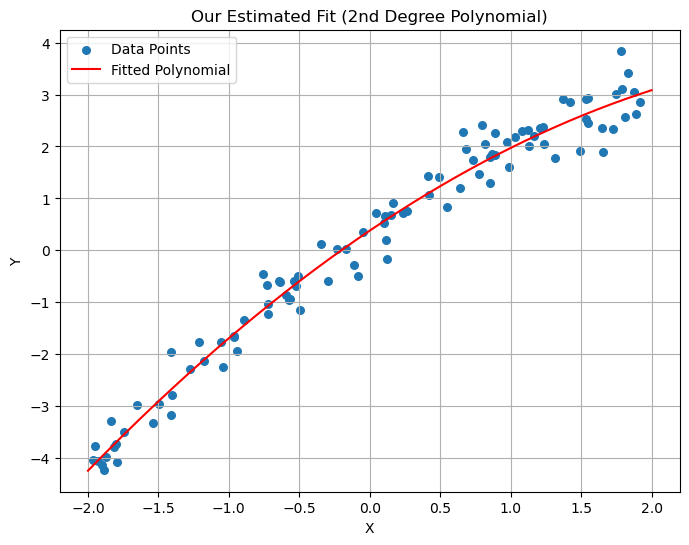

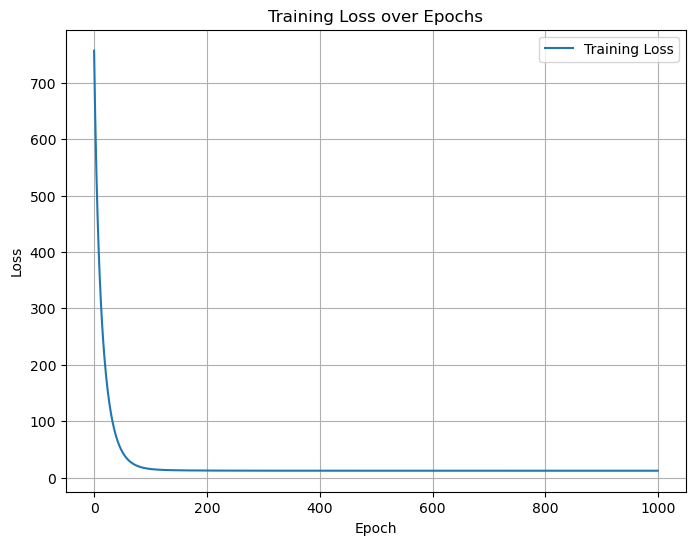

Learned parameters (polynomial coefficients):
  Constant term (w0): 0.3807, True: 0.3623
  Coefficient for x (w1): 1.8308, True: 1.8250
  Coefficient for x^2 (w2): -0.2399, True: -0.2654


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time


def generate_data(m, w_true):
    """Generates data for a 2nd-degree polynomial with noise."""
    XX = 4 * np.random.rand(m) - 2  # x values between -2 and 2
    YY = w_true[0] + w_true[1] * XX + w_true[2] * (XX ** 2)
    YY += np.random.normal(scale=0.3, size=YY.size)  # Add noise
    return XX, YY


def plot_fit(XX, YY, w):
    """Plots the data and the fitted polynomial."""
    plt.figure(figsize=(8, 6))
    plt.title('Our Estimated Fit (2nd Degree Polynomial)')
    plt.scatter(XX, YY, label='Data Points', s=30)

    x_vals = np.linspace(-2, 2, 200)  # x values for plotting the curve
    X_plot = np.stack([np.ones_like(x_vals), x_vals, x_vals**2], axis=1)
    # we also use matmul (np.dot) to make our predictions
    y_vals = X_plot @ w.arr  # Predict using the model

    plt.plot(x_vals, y_vals, 'r', label='Fitted Polynomial')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_loss(training_loss):
    """Plots the training loss over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


def train(x, y, params, lr, epochs):
    w = Tensor(params, requires_grad=True)
    training_loss = []
    sample_size = len(x)

    start_time = time.time()

    y = Tensor(y.reshape(-1, 1), requires_grad=False)
    for epoch in range(epochs):
        w.zeroGrad()

        X = Tensor(np.stack([np.ones_like(x), x, x**2], axis=1), requires_grad=False)

        out = X @ w
        loss = ((out - y) ** 2).sum()

        loss.backprop()
        training_loss.append(loss.arr)

        # we use the avg loss over all of the data samples
        w = w - lr * w.grad / sample_size

    end_time = time.time()
    print(f"Training took (secs): {end_time - start_time:.4f}")

    return w, training_loss


m = 100  # Number of data points
lr = 0.01  # Learning rate
epochs = 1000  # Number of epochs

# Generate *true* weights for a 2nd-degree polynomial
w_true = np.random.normal(size=(3,))

# Generate data using the *true* polynomial + noise
XX, YY = generate_data(m, w_true)

# Initialize weights for our model (to be learned)
w_init = np.random.normal(size=(3, 1))  # w0, w1, w2

# Train the model
w, training_loss = train(XX, YY, w_init, lr, epochs)

# Plot the results
plot_fit(XX, YY, w)
plot_loss(training_loss)

# Print the learned and true coefficients
print("Learned parameters (polynomial coefficients):")
print(f"  Constant term (w0): {w.arr[0, 0]:.4f}, True: {w_true[0]:.4f}")
print(f"  Coefficient for x (w1): {w.arr[1, 0]:.4f}, True: {w_true[1]:.4f}")
print(f"  Coefficient for x^2 (w2): {w.arr[2, 0]:.4f}, True: {w_true[2]:.4f}")